# Building a basic MNIST classifier

In [0]:
# the dataset has to be stored on your google drive. The following libraies are used to access it. 
# follow the instructions in the promt after running this cell 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os 
print(os.listdir('gdrive/My Drive/MLWorkshop1'))        # checking that the dataset is in your folder 
filepath = 'gdrive/My Drive/MLWorkshop1'

['mnist_test.csv', 'mnist_train.csv']


In [0]:
# the dataset is composed of a test file and a train file. 
# You can download it here https://www.kaggle.com/oddrationale/mnist-in-csv
train_data = open(filepath+"/mnist_train.csv").readlines()
test_data = open(filepath+"/mnist_test.csv").readlines()

In [0]:
# importing the necessary libraries.

import torch            # general pytorch
import torch.nn.functional as F         # simply renaming this to F so it's easier 
import torch.nn as nn                   # these are generic neural network related functions 
import torch.optim as optim             # here we can find the optimisers (SGD, Adam, Adagrad, etc...)

# for almost all operations you can perform in pytorch there is a functional version and an nn.Module inheriting class.
# We will use a mixture
# we will create objects for the individual layers of our network, but we will use the functional version of the non-linearity functions 

import numpy as np              # linear algebra in python (pytorch does everything this does and a lot more, but other libraries don't support pytorch's datatype)
import random

In [0]:
def prepare_data(raw_data):
    data = []           # we will have a list of all the examples in pytorch's format 
    for line in raw_data:
        # lines when reading the datase are strings, with numbers separated by commas. we split them, cast to int and build a torch.Tensor object
        # then we unsqueeze along the first dimension so we go from shape = (785) to shape = (1, 785)  we need this so that we can conactenate them later 
        datapoint = torch.FloatTensor([int(i) for i in line.split(',')]).unsqueeze(0)      
        data.append(datapoint)
    return data


# removing the header from train_data, we want everything except the fist 
train_data = prepare_data(train_data[1:])
test_data = prepare_data(test_data[1:])

random.shuffle(train_data)
random.shuffle(test_data)

In [0]:
# feeding the model more than one example at a time leverages the computer's parallel processing power.
# This is especially effective when running models on GPUs 

def get_batch(b_size=128):
    i = random.randint(0, len(train_data)-b_size)
    batch = torch.cat(train_data[i: i+b_size], 0)
    X = batch[:, 1:]            # these are the actual pixel values 
    targets = batch[:, 0]       # the first element in every example is the correct class 
    return X, targets.long()    # we cast the targets to the long datatype because this is what our error function will take as parameter

Let's plot an example datapoint 

Picked a  5


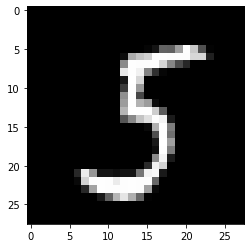

In [0]:
import matplotlib.pyplot as plt         # used for plotting graphs
%matplotlib inline     

x, y = get_batch(1)

print("Picked a ", y.item())
plt.imshow(x.view(28, 28).numpy(), cmap='gray')

Defining out model

In [0]:
class FeedForwardNetwork(nn.Module):            # inheriting nn.Module so that pytorch recognizes it as a pytorch model

    def __init__(self):
        """ here we initialise the layers """
        super(FeedForwardNetwork, self).__init__()
        # nn.Linear defines a simple linear layer, so y = Wx + b 
        self.layer0 = nn.Linear(784, 512)           # the parameters passed are the input size and the output size. They can be anything you want 
        self.layer1 = nn.Linear(512, 256)               # they specify the shape of W and b
        self.output_layer = nn.Linear(256, 10)         # since we are classifying over 10 classes we want the output size to be 10

    def forward(self, X):       # this is the function that we will call to run the model 
        h0 = F.relu(self.layer0(X))         # ReLU is our non-linearity (rectified lienar unit)
        h1 = F.relu(self.layer1(h0))
        output = self.output_layer(h1)
        return output

Training our network

In [0]:

model = FeedForwardNetwork()
model_optim = optim.SGD(model.parameters(), lr=1e-3)        # creating the optimizer using SGD, telling what variables it can optimize and what the learning rate is 

iter_num = int(1e4)
for i in range(iter_num):           # training for iter_num number of steps 
                            # when dealing with a proper task we would train in number of epochs (full passes over the full dataset)
                            # being just a demo, and given that this dataset is so easy we don't need this now 
    x, y = get_batch()
    y_ = model(x)           # running the model, we don't need to call mdoel.forward(x) because pytorch automatigically does that for us on nn.Module obejcts  
    loss = F.cross_entropy(y_, y)       # our loss function. Basically all we are trying to do is minimize this error function 
    
    loss.backward()         # calculates the gradients wrt each parameter and stores them 
    model_optim.step()      # performs one parameter update using the optimizer we defined previously 
    model_optim.zero_grad()   # clears the gradients. they would otherwise be accumulated through time. this would be useful for example with recurrent architectures 
    
    if i % 1000 == 0:
        print("step", i, "cost", loss.item())

step 0 cost 12.9999418258667
step 1000 cost 0.0638662800192833
step 2000 cost 0.1590200513601303
step 3000 cost 0.041479840874671936
step 4000 cost 0.032555703073740005
step 5000 cost 0.06941087543964386
step 6000 cost 0.016830211505293846
step 7000 cost 0.012399942614138126
step 8000 cost 0.016072439029812813
step 9000 cost 0.008698497898876667


Finding our model's accuracy with the test set. 

In [0]:
# we will simply evaluate all the examples in the test set, and store the wrong ones so we can later look at them 

wrong = []
for digit in test_data:
    x = digit[:, 1:]
    y = digit[:, 0]
    y_ = F.softmax(model(x), 1).detach().numpy()
    predicted_class = np.argmax(y_)
    if predicted_class != y:
        wrong.append({"predicted": predicted_class,
                      "model output": y_,
                      "model input": x, 
                      "true class": y})


In [0]:
print("accuracy is " , (len(test_data) - len(wrong)) / len(test_data))

accuracy is  0.9709


Plotting some wrong examples
hopefully the examples our network got wrong are also hard to classify for ourselves, this means that our network is good. 

In [0]:
def plot_wrong(wrong_num=5):
    for i in range(wrong_num):
        wrong_example = random.choice(wrong)
        print("Image is a ", wrong_example['true class'].item())
        plt.imshow(wrong_example["model input"].view(28, 28).numpy(), cmap="gray")
        plt.show()
        print("Predicted class", wrong_example["predicted"])
        plt.bar(list(range(10)), wrong_example['model output'].squeeze(0))
        plt.show()
        

we will also plot the output vector of our network, that shows the probabilities it assigned to each possible outcome. Often when it makes a mistake it assigns high probabilities to more than one possible output, meaning that it is "confused". 

Image is a  4.0


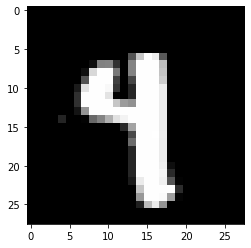

Predicted class 9


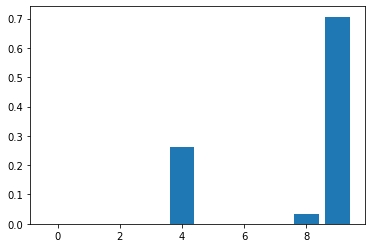

Image is a  5.0


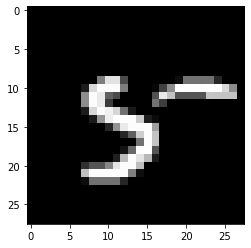

Predicted class 8


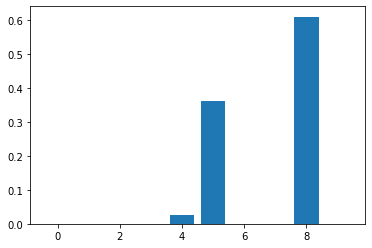

Image is a  7.0


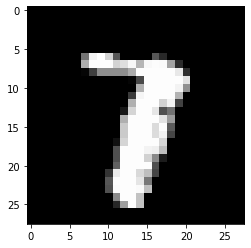

Predicted class 3


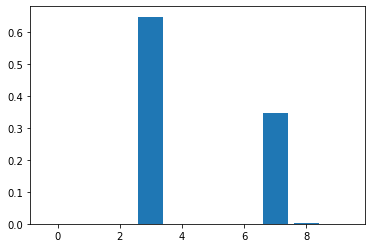

Image is a  8.0


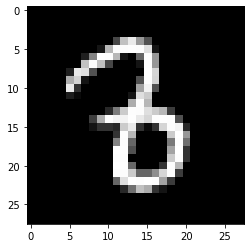

Predicted class 3


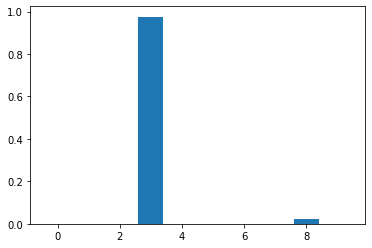

Image is a  8.0


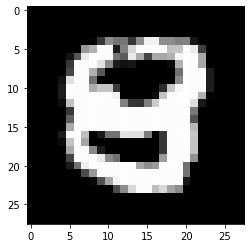

Predicted class 4


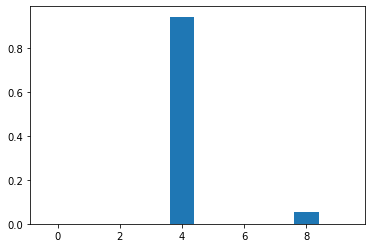

In [0]:
plot_wrong(wrong_num=5)